<a href="https://colab.research.google.com/github/diegomrodrigues/generative_models_experiments/blob/main/KL%20Divergence%20x%20Log-likelihood.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

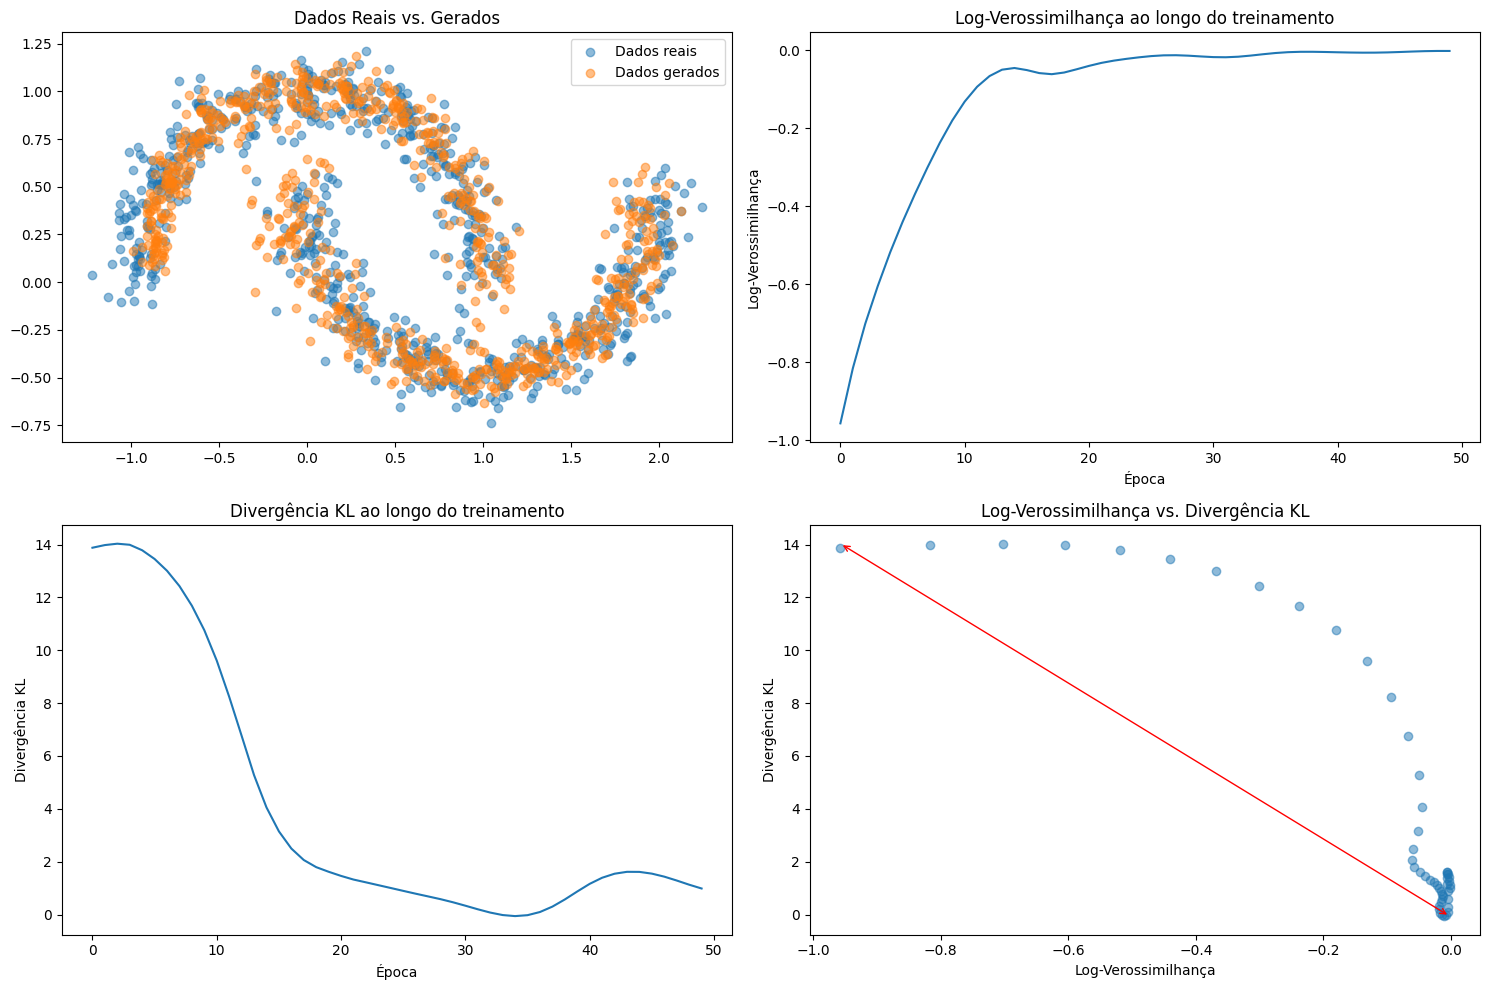

In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split
from scipy.stats import gaussian_kde
import warnings

# Ignorar avisos específicos
warnings.filterwarnings("ignore", category=RuntimeWarning)

# Configuração do seed para reprodutibilidade
torch.manual_seed(42)
np.random.seed(42)

# Geração de dados
X, _ = make_moons(n_samples=1000, noise=0.1)
X_train, X_test = train_test_split(X, test_size=0.2, random_state=42)
X_train_tensor = torch.FloatTensor(X_train)

# Modelo gerador (rede neural)
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(2, 16),
            nn.ReLU(),
            nn.Linear(16, 32),
            nn.ReLU(),
            nn.Linear(32, 2)
        )

    def forward(self, x):
        return self.model(x)

generator = Generator()

# Função de perda (log-verossimilhança negativa)
criterion = nn.MSELoss()

# Otimizador
optimizer = optim.Adam(generator.parameters(), lr=0.01)

# Treinamento
n_epochs = 50
log_likelihoods = []
kl_divergences = []

for epoch in range(n_epochs):
    optimizer.zero_grad()

    # Forward pass
    outputs = generator(X_train_tensor)

    # Cálculo da log-verossimilhança
    log_likelihood = -criterion(outputs, X_train_tensor)
    log_likelihoods.append(log_likelihood.item())

    # Cálculo da divergência KL (aproximada)
    kde_real = gaussian_kde(X_train.T)
    kde_gen = gaussian_kde(outputs.detach().numpy().T)
    x_range = np.linspace(-2, 3, 100)
    y_range = np.linspace(-1.5, 2, 100)
    XX, YY = np.meshgrid(x_range, y_range)
    positions = np.vstack([XX.ravel(), YY.ravel()])

    # Evitar divisão por zero e log de zero
    real_density = np.maximum(kde_real(positions), 1e-10)
    gen_density = np.maximum(kde_gen(positions), 1e-10)
    kl_div = np.mean(np.log(real_density / gen_density))
    kl_divergences.append(kl_div)

    # Backward pass e otimização
    loss = -log_likelihood
    loss.backward()
    optimizer.step()

# Visualização
plt.figure(figsize=(15, 10))

# Plot dos dados reais e gerados
plt.subplot(2, 2, 1)
plt.scatter(X_train[:, 0], X_train[:, 1], alpha=0.5, label='Dados reais')
generated = generator(X_train_tensor).detach().numpy()
plt.scatter(generated[:, 0], generated[:, 1], alpha=0.5, label='Dados gerados')
plt.title('Dados Reais vs. Gerados')
plt.legend()

# Plot da log-verossimilhança
plt.subplot(2, 2, 2)
plt.plot(log_likelihoods)
plt.title('Log-Verossimilhança ao longo do treinamento')
plt.xlabel('Época')
plt.ylabel('Log-Verossimilhança')

# Plot da divergência KL
plt.subplot(2, 2, 3)
plt.plot(kl_divergences)
plt.title('Divergência KL ao longo do treinamento')
plt.xlabel('Época')
plt.ylabel('Divergência KL')

# Plot da relação entre log-verossimilhança e divergência KL
plt.subplot(2, 2, 4)
plt.scatter(log_likelihoods, kl_divergences, alpha=0.5)
plt.title('Log-Verossimilhança vs. Divergência KL')
plt.xlabel('Log-Verossimilhança')
plt.ylabel('Divergência KL')

# Adicionar setas bidirecionais
arrow_start = (min(log_likelihoods), max(kl_divergences))
arrow_end = (max(log_likelihoods), min(kl_divergences))
plt.annotate('', xy=arrow_end, xytext=arrow_start,
             arrowprops=dict(arrowstyle='<->', color='red'))

plt.tight_layout()
plt.show()

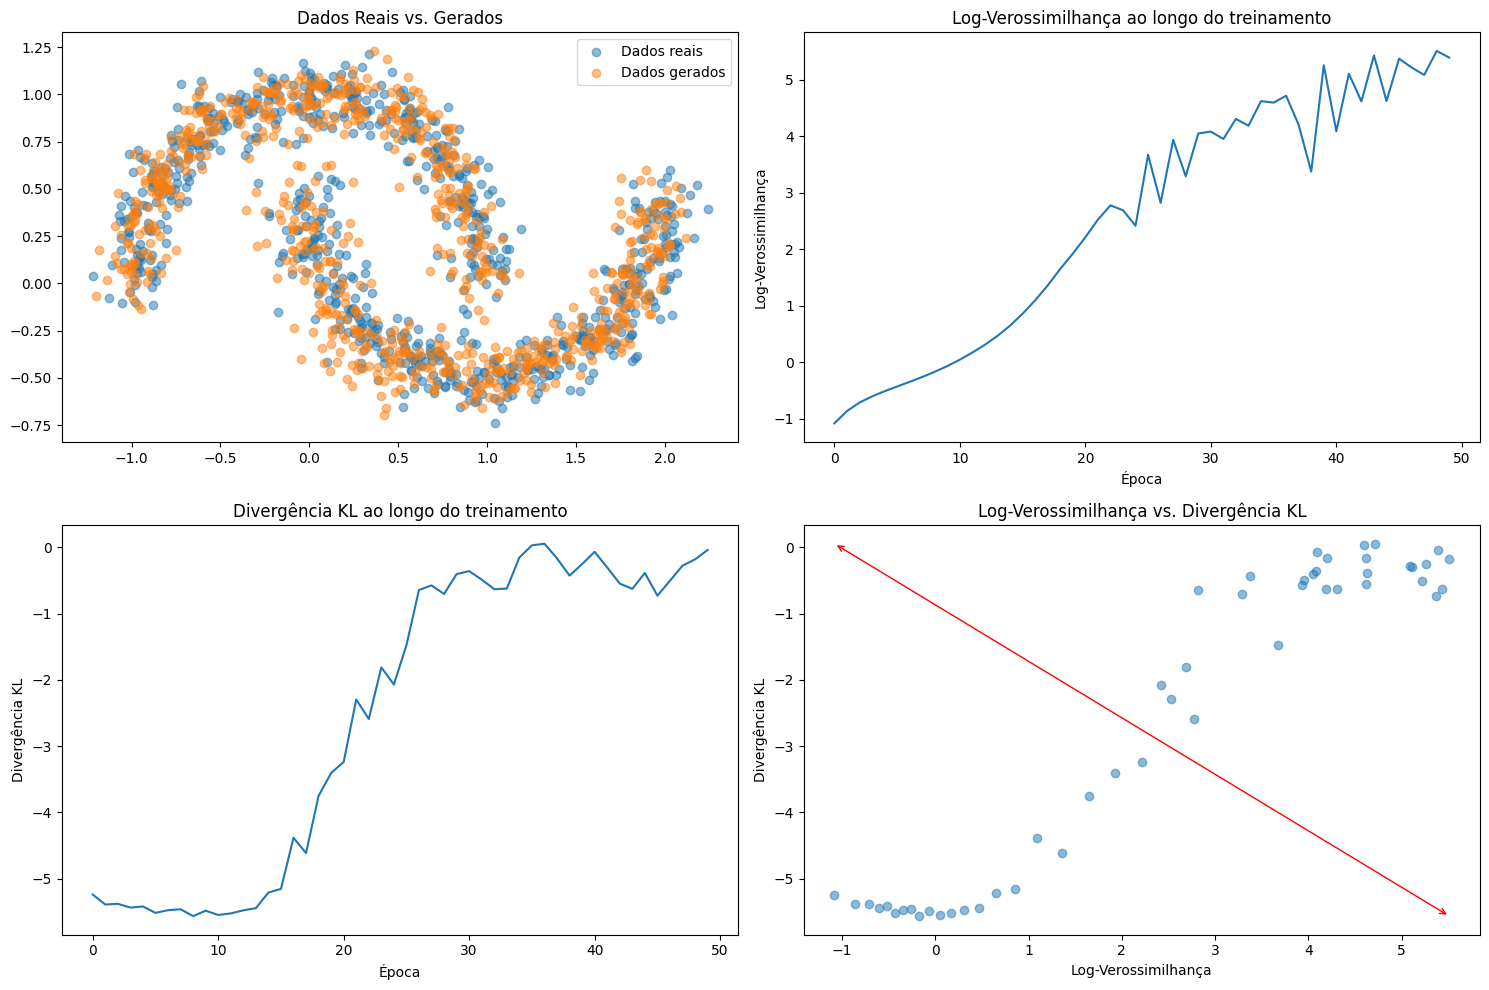

In [6]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split
from scipy.stats import gaussian_kde
import warnings

# Ignorar avisos específicos
warnings.filterwarnings("ignore", category=RuntimeWarning)

# Configuração do seed para reprodutibilidade
torch.manual_seed(42)
np.random.seed(42)

# Geração de dados
X, _ = make_moons(n_samples=1000, noise=0.1)
X_train, X_test = train_test_split(X, test_size=0.2, random_state=42)
X_train_tensor = torch.FloatTensor(X_train)

# Modelo gerador (rede neural)
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(2, 16),
            nn.ReLU(),
            nn.Linear(16, 32),
            nn.ReLU(),
            nn.Linear(32, 4)  # Output 4 values: mean_x, mean_y, log_var_x, log_var_y
        )

    def forward(self, x):
        return self.model(x)

generator = Generator()

# Gaussian negative log-likelihood loss
def gaussian_nll_loss(y_pred, y_true):
    mean, log_var = y_pred.split(2, dim=1)
    var = torch.exp(log_var)
    return 0.5 * torch.sum(log_var + (y_true - mean)**2 / var, dim=1).mean()

# Otimizador
optimizer = optim.Adam(generator.parameters(), lr=0.01)

# Treinamento
n_epochs = 50
log_likelihoods = []
kl_divergences = []

for epoch in range(n_epochs):
    optimizer.zero_grad()

    # Forward pass
    outputs = generator(X_train_tensor)

    # Cálculo da log-verossimilhança
    loss = gaussian_nll_loss(outputs, X_train_tensor)
    log_likelihood = -loss.item()
    log_likelihoods.append(log_likelihood)

    # Cálculo da divergência KL (aproximada)
    with torch.no_grad():
        mean, log_var = outputs.split(2, dim=1)
        generated = torch.normal(mean, torch.exp(0.5 * log_var))
        kde_real = gaussian_kde(X_train.T)
        kde_gen = gaussian_kde(generated.numpy().T)
        x_range = np.linspace(-2, 3, 100)
        y_range = np.linspace(-1.5, 2, 100)
        XX, YY = np.meshgrid(x_range, y_range)
        positions = np.vstack([XX.ravel(), YY.ravel()])

        # Evitar divisão por zero e log de zero
        real_density = np.maximum(kde_real(positions), 1e-10)
        gen_density = np.maximum(kde_gen(positions), 1e-10)
        kl_div = np.mean(np.log(real_density / gen_density))
        kl_divergences.append(kl_div)

    # Backward pass e otimização
    loss.backward()
    optimizer.step()

# Visualização
plt.figure(figsize=(15, 10))

# Plot dos dados reais e gerados
plt.subplot(2, 2, 1)
plt.scatter(X_train[:, 0], X_train[:, 1], alpha=0.5, label='Dados reais')
with torch.no_grad():
    outputs = generator(X_train_tensor)
    mean, log_var = outputs.split(2, dim=1)
    generated = torch.normal(mean, torch.exp(0.5 * log_var))
plt.scatter(generated[:, 0], generated[:, 1], alpha=0.5, label='Dados gerados')
plt.title('Dados Reais vs. Gerados')
plt.legend()

# Plot da log-verossimilhança
plt.subplot(2, 2, 2)
plt.plot(log_likelihoods)
plt.title('Log-Verossimilhança ao longo do treinamento')
plt.xlabel('Época')
plt.ylabel('Log-Verossimilhança')

# Plot da divergência KL
plt.subplot(2, 2, 3)
plt.plot(kl_divergences)
plt.title('Divergência KL ao longo do treinamento')
plt.xlabel('Época')
plt.ylabel('Divergência KL')

# Plot da relação entre log-verossimilhança e divergência KL
plt.subplot(2, 2, 4)
plt.scatter(log_likelihoods, kl_divergences, alpha=0.5)
plt.title('Log-Verossimilhança vs. Divergência KL')
plt.xlabel('Log-Verossimilhança')
plt.ylabel('Divergência KL')

# Adicionar setas bidirecionais
arrow_start = (min(log_likelihoods), max(kl_divergences))
arrow_end = (max(log_likelihoods), min(kl_divergences))
plt.annotate('', xy=arrow_end, xytext=arrow_start,
             arrowprops=dict(arrowstyle='<->', color='red'))

plt.tight_layout()
plt.show()